In [1]:
%load_ext lab_black
%matplotlib inline

import os
import torch
import numpy as np
import pandas as pd
from collections import defaultdict
import tensorboard as tb
from pathlib import Path
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context("paper")
sns.despine()
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 14,
    "font.size": 18,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
}
plt.rcParams.update(tex_fonts)

results = "/home/luis/repos/bayesrul/results/ncmapss/runs"

<Figure size 640x480 with 0 Axes>

In [2]:
conf = OmegaConf.load(f"{results}/HNN/0/.hydra/config.yaml")
print(conf)

{'task_name': 'train_hnn', 'tags': ['ncmapss', 'frequentist', 'hnn'], 'train': True, 'test': True, 'ckpt_path': None, 'seed': 1, 'datamodule': {'_target_': 'bayesrul.data.ncmapss.dataset.NCMAPSSDataModule', 'data_path': '${paths.data_dir}/ncmapss/', 'batch_size': 250, 'all_dset': False, 'num_workers': 12, 'pin_memory': True}, 'model': {'net': {'_target_': 'bayesrul.models.nets.inception.Inception', 'win_length': '???', 'n_features': '???', 'activation': 'relu', 'dropout': 0}, '_target_': 'bayesrul.models.frequentist.HNN', 'optimizer': {'_target_': 'torch.optim.Adam', '_partial_': True, 'lr': 0.001574, 'weight_decay': 0.001}, 'p_dropout': 0, 'mc_samples': 0}, 'callbacks': {'model_checkpoint': {'_target_': 'pytorch_lightning.callbacks.ModelCheckpoint', 'dirpath': '${paths.output_dir}/checkpoints', 'filename': 'epoch_{epoch}-step_{step}', 'monitor': 'nll/val', 'verbose': False, 'save_last': True, 'save_top_k': 1, 'mode': 'min', 'auto_insert_metric_name': False, 'save_weights_only': False,

In [2]:
cumul = []
path = Path(f"{results}")
for yaml in path.glob("**/config.yaml"):
    conf = OmegaConf.load(yaml)
    cumul.append(
        (
            f"{yaml.parts[8]}_{int(yaml.parts[9]):03d}",
            conf.tags[1],
            conf.datamodule.batch_size,
            conf.callbacks.early_stopping.patience,
        )
    )
runs = pd.DataFrame.from_records(
    cumul, columns=["model", "model_type", "batch_size", "early_stop_patience"]
)
runs

,model,model_type,batch_size,early_stop_patience
0,RAD_001,bayesian,100,20
1,RAD_003,bayesian,100,20
2,RAD_002,bayesian,100,20
3,RAD_000,bayesian,100,20
4,RAD_004,bayesian,100,20
5,FO_001,bayesian,100,20
6,FO_003,bayesian,100,20
7,FO_002,bayesian,100,20
8,FO_000,bayesian,100,20
9,FO_004,bayesian,100,20


In [3]:
cumul = []
path = Path(f"{results}")
for i in path.glob("**/*.ckpt"):
    if i.stem == "last":
        continue
    cumul.append(
        (
            i.parts[8],
            f"{i.parts[8]}_{int(i.parts[9]):03d}",
            int(i.stem.split("-")[1].split("_")[-1]),
            int(i.stem.split("-")[0].split("_")[-1]),
            # hparams["batch_size"],
            # hparams["early_stop"],
        )
    )
runs = pd.DataFrame.from_records(
    cumul,
    columns=[
        "method",
        "model",
        "max_steps",
        "max_epochs",
        # "model_type",
        # "batch_size",
        # "early_stop",
    ],
).merge(runs, on="model")
runs

,method,model,max_steps,max_epochs,model_type,batch_size,early_stop_patience
0,RAD,RAD_001,202470,84,bayesian,100,20
1,RAD,RAD_003,145302,60,bayesian,100,20
2,RAD,RAD_002,104808,43,bayesian,100,20
3,RAD,RAD_000,169122,70,bayesian,100,20
4,RAD,RAD_004,140538,58,bayesian,100,20
5,FO,FO_001,240582,100,bayesian,100,20
6,FO,FO_003,328716,137,bayesian,100,20
7,FO,FO_002,276312,115,bayesian,100,20
8,FO,FO_000,283458,118,bayesian,100,20
9,FO,FO_004,269166,112,bayesian,100,20


In [4]:
cumul = []
path = Path(f"{results}")
for log in path.glob("**/*.log"):
    model = f"{log.parts[8]}_{int(log.parts[9]):03d}"
    with open(log) as f:
        line = f.readlines()
        t = round(float(line[0].split(":")[-1].split("(")[0]) / 3600, 2)
        cumul.append((model, t))
runs = pd.DataFrame.from_records(cumul, columns=["model", "hours"]).merge(
    runs, on="model"
)
runs

,model,hours,method,max_steps,max_epochs,model_type,batch_size,early_stop_patience
0,RAD_001,8.49,RAD,202470,84,bayesian,100,20
1,RAD_003,6.58,RAD,145302,60,bayesian,100,20
2,RAD_002,5.18,RAD,104808,43,bayesian,100,20
3,RAD_000,7.40,RAD,169122,70,bayesian,100,20
4,RAD_004,6.49,RAD,140538,58,bayesian,100,20
5,FO_001,18.72,FO,240582,100,bayesian,100,20
6,FO_003,23.31,FO,328716,137,bayesian,100,20
7,FO_002,19.80,FO,276312,115,bayesian,100,20
8,FO_000,21.65,FO,283458,118,bayesian,100,20
9,FO_004,19.62,FO,269166,112,bayesian,100,20


In [22]:
runs_agg = runs.groupby("method").agg(
    {"max_epochs": ["mean", "std"], "hours": ["mean", "std"]}
)
runs_agg.columns = ["_".join(a) for a in runs_agg.columns.to_flat_index()]
runs_agg

,max_epochs_mean,max_epochs_std,hours_mean,hours_std
method,,,,
FO,116.4,13.390295,20.620,1.842512
HNN,177.5,107.170943,1.351,0.708715
LRT,80.6,19.552493,8.654,1.645017
MCD,241.0,52.454742,6.168,0.924619
RAD,63.0,15.198684,6.828,1.222812


In [34]:
def to_mean_std(
    df,
):
    precision = 1
    df = df.assign(
        epochs=lambda x: x.max_epochs_mean.round(precision).astype(str)
        + " $\pm$ "
        + x.max_epochs_std.round(precision).astype(str),
        hours=lambda x: x.hours_mean.round(precision).astype(str)
        + " $\pm$ "
        + x.hours_std.round(precision).astype(str),
    )[["method", "epochs", "hours"]]
    return df

def latex_formatted(df: pd.DataFrame, highlight_min: bool = True) -> str:
    s = df.style
    if highlight_min:
        s = s.highlight_min(subset=df.columns[1:], props="textbf:--rwrap;", axis=0)
    s = s.format(precision=3)
    return s.hide(axis="index").to_latex(hrules=True).replace("_", " ")

In [35]:
print(
    latex_formatted(
        to_mean_std(runs_agg.reset_index().sort_values("max_epochs_mean")),
        highlight_min=False,
    )
)

\begin{tabular}{lll}
\toprule
method & epochs & hours \\
\midrule
RAD & 63.0 $\pm$ 15.2 & 6.8 $\pm$ 1.2 \\
LRT & 80.6 $\pm$ 19.6 & 8.7 $\pm$ 1.6 \\
FO & 116.4 $\pm$ 13.4 & 20.6 $\pm$ 1.8 \\
HNN & 177.5 $\pm$ 107.2 & 1.4 $\pm$ 0.7 \\
MCD & 241.0 $\pm$ 52.5 & 6.2 $\pm$ 0.9 \\
\bottomrule
\end{tabular}



In [41]:
runs.to_csv("runs/runs.csv")

In [42]:
experiment_ids = ["g4vFkAUJS9WOgzQI3DCkSA"]
for experiment_id in experiment_ids:
    filename = f"runs/{experiment_id}.parquet"
    if not Path(filename).exists():
        experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
        df = experiment.get_scalars(include_wall_time=True)
        df.to_parquet(f"{filename}")

In [43]:
runs = (
    pd.concat(
        [
            pd.read_parquet(f"runs/{experiment_id}.parquet")
            for experiment_id in experiment_ids
        ]
    )
    .assign(
        method=lambda x: x.run.map(lambda x: x.split("/")[0]),
        # model=lambda x: x.method.map(lambda x: "_".join(x.split("_")[1])),
        model_id=lambda x: x.run.map(lambda x: x.split("/")[1])
        .astype(int)
        .map("{:03d}".format),
        model=lambda x: x.method + "_" + x.model_id,
    )
    # .drop("model_id", axis=1)
    .merge(
        pd.read_csv("runs/runs.csv")[
            ["model_type", "model", "max_epochs", "max_steps", "batch_size"]
        ],
        on="model",
        how="left",
    )
    .assign(epoch=lambda x: np.ceil(x.step * x.max_epochs / x.max_steps))
)
runs

,run,tag,step,value,wall_time,method,model_id,model,model_type,max_epochs,max_steps,batch_size,epoch
0,FO/0/tensorboard/version_0,elbo/train,2381,0.017300,1.667294e+09,FO,000,FO_000,bayesian,118,283458,100,1.0
1,FO/0/tensorboard/version_0,elbo/train,4763,0.014738,1.667295e+09,FO,000,FO_000,bayesian,118,283458,100,2.0
2,FO/0/tensorboard/version_0,elbo/train,7145,0.013314,1.667296e+09,FO,000,FO_000,bayesian,118,283458,100,3.0
3,FO/0/tensorboard/version_0,elbo/train,9527,0.011926,1.667296e+09,FO,000,FO_000,bayesian,118,283458,100,4.0
4,FO/0/tensorboard/version_0,elbo/train,11909,0.010622,1.667297e+09,FO,000,FO_000,bayesian,118,283458,100,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54870,RAD/4/tensorboard/version_0,sharp/val,178649,9.945289,1.667415e+09,RAD,004,RAD_004,bayesian,58,140538,100,74.0
54871,RAD/4/tensorboard/version_0,sharp/val,181031,9.061185,1.667415e+09,RAD,004,RAD_004,bayesian,58,140538,100,75.0
54872,RAD/4/tensorboard/version_0,sharp/val,183413,12.397573,1.667416e+09,RAD,004,RAD_004,bayesian,58,140538,100,76.0
54873,RAD/4/tensorboard/version_0,sharp/val,185795,9.599664,1.667416e+09,RAD,004,RAD_004,bayesian,58,140538,100,77.0


In [108]:
def val_loss_per_method(model_type):
    tag = "gaussian_nll/val" if model_type == "frequentist" else "elbo/val"
    for method in runs.query("model_type==@model_type")["method"].unique().tolist():
        df = (
            runs.query("method==@method and tag==@tag")
            .groupby("run")[["model", "value"]]
            .min()
            .groupby("model")
            .mean()
            .reset_index()
            .merge(runs[["model", "method", "batch_size"]], on="model", how="left")
            .groupby("model")
            .first()
            .sort_values("value")
        )
        yield df


cumul = []
for model_type in ["frequentist", "bayesian"]:
    for df in val_loss_per_method(model_type):
        cumul.append(df)
val_loss = pd.concat(cumul).reset_index()
val_loss
#val_loss_per_method("frequentist")
#val_loss_per_method("bayesian")

<generator object val_loss_per_method at 0x7f720d59d9e0>

In [104]:
best = val_loss.loc[val_loss.groupby("method")["value"].idxmin()]["model"].to_list()
pd.DataFrame(best, columns=["best_model"]).to_csv("runs/best.csv")
best

['FO_000', 'LRT_000', 'RAD_000']

In [44]:
def plot_loss(
    df,
    tags,
    xticks=None,
    log=True,
):
    g = (
        sns.relplot(
            data=df,
            x="epoch",
            y="value",
            hue="method",
            col="tag",
            # col_wrap=2,
            kind="line",
            col_order=tags,
            height=3,
            aspect=1.1,
            facet_kws=dict(sharey=False),
        )
        .set_titles(row_template="", col_template="{col_name}", size=12)
        .set(ylabel=None, xticks=xticks)
    )
    if log:
        g.set(yscale="log")
    sns.move_legend(
        g,
        "upper center",
        bbox_to_anchor=(0.45, 1.02),
        ncol=3,
    )
    leg = g._legend
    leg.set_title("")
    plt.setp(leg.get_texts(), fontsize="12")
    return g

cumul = []
for (m, me), tag in runs.groupby(["model", "tag"]):
    tag["value"] = (
        tag["value"]
        .ewm(
            span=500
            # if m.startswith("DEEP")
            # # or m.startswith("RADIAL"))
            # and me.startswith("mse")
            # else 3
        )
        .mean()
    )
    cumul.append(tag)
runs_smooth = pd.concat(cumul).reset_index(drop=True)

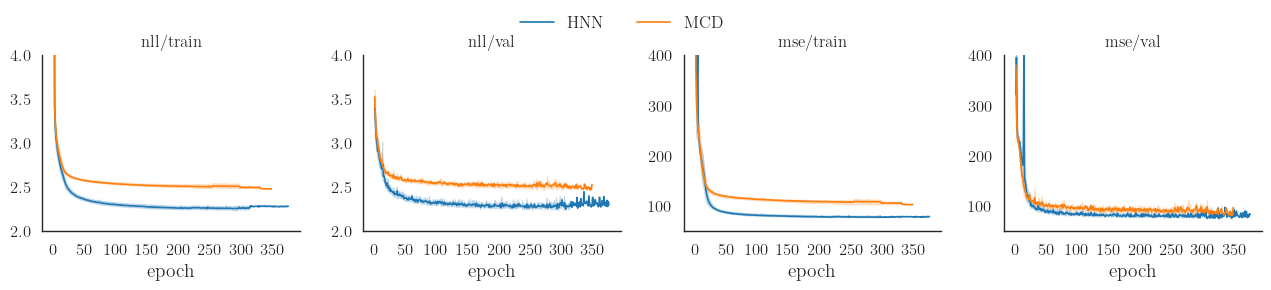

In [46]:
exclude = ["HNN_001", "HNN_006"]
tags = ["nll/train", "nll/val", "mse/train", "mse/val"]
g = plot_loss(
    runs.query(
        f"model_type=='frequentist' and tag in {tags} and model not in {exclude}"
    )[::],
    tags,
    log=False,
    xticks=range(0, 400, 50),
)
axes = g.axes
axes[0, 0].set_ylim(2, 4)
axes[0, 1].set_ylim(2, 4)
axes[0, 2].set_ylim(50, 400)
axes[0, 3].set_ylim(50, 400)
g.tight_layout()
g.savefig("figs/freq_loss.pdf")

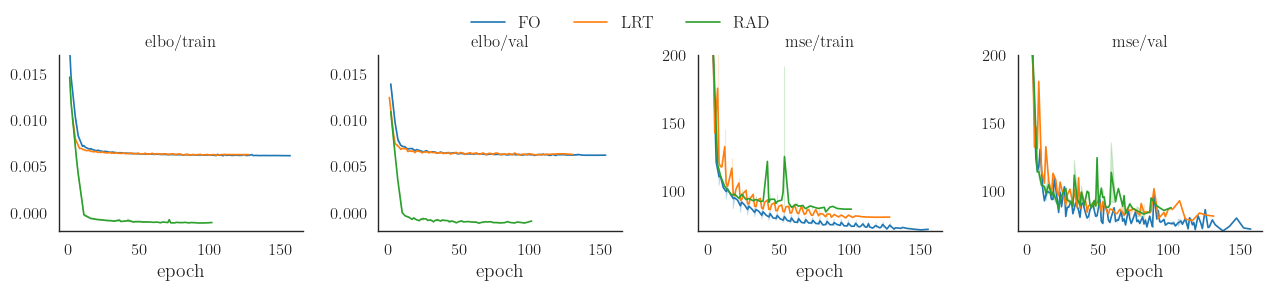

In [47]:
tags = ["elbo/train", "elbo/val", "mse/train", "mse/val"]
g = plot_loss(
    # runs_smooth.query(f"model in {best_bayesian} and tag in {tags}")[::10],
    runs.query(f"model_type=='bayesian' and tag in {tags}")[::5],
    tags,
    log=False,
    xticks=range(0, 200, 50),
)
axes = g.axes
axes[0, 0].set_ylim(-0.002, 0.017)
axes[0, 1].set_ylim(-0.002, 0.017)
axes[0, 2].set_ylim(70, 200)
axes[0, 3].set_ylim(70, 200)
g.tight_layout()
g.savefig("figs/bayesian_loss.pdf")